# Machine Learning to detect pants

In this notebook, we will be training our pants model to use on predicitions and therefore, be able to detect the required pants

### Library Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import itertools

%matplotlib inline
from IPython.display import Image
from PIL import Image as ImagePL
from scipy.ndimage import zoom


# Libraries for TensorFlow
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import resnet50
from tensorflow.keras import backend as K

from tensorflow.keras.applications.resnet50 import preprocess_input

import tensorflow as tf

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import class_weight
from sklearn.model_selection import KFold

### Load data

Dataset extracted from: https://www.kaggle.com/agrigorev/clothing-dataset-full

References from 

https://www.kaggle.com/pintu161/transfer-learning-in-pytorch-using-resnet18/notebook

https://www.kaggle.com/marissafernandes/clothes-image-classifier/notebook

https://www.kaggle.com/viratkothari/image-classification-transfer-learning-resnet50

In [2]:
originalCSV = pd.read_csv('Data/images.csv')
originalCSV.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


Deleting unnecessary or wrong images

In [3]:
def imageCleaning(path):
    extensions = []
    bad_list = []
    for filee in os.listdir(path):
        file_path = os.path.join(path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        try:
            im = ImagePL.open(file_path)
            rgb_im = im.convert('RGB')
            if filee.split('.')[1] not in extensions:
                extensions.append(filee.split('.')[1])
        except:
            print("Error with " + file_path)
            bad_list.append(file_path)

#imageCleaning('Data\images_compressed')

In [4]:
typeOfData = originalCSV["label"].value_counts()
typeOfData

T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: label, dtype: int64

## Loading Data

In [5]:
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
EPOCHS = 20

### Data set generators

In [6]:
def createTrainSetAndValidationSet(data):
    generator = image.ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT
    )
    train_set = generator.flow_from_dataframe(
        dataframe=data,
        x_col="image",
        y_col="label",
        target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    val_set = generator.flow_from_dataframe(
        dataframe=data,
        x_col="image",
        y_col="label",
        target_size=(WIDTH, HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    num_classes = len(train_set.class_indices)
    print("Total classes:", num_classes)
    return train_set, val_set, num_classes

### Checkpoint generator

In [7]:
def checkPointCreation(checkpoint_path):
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    return cp_callback

### Weights generator

In [8]:
def generateWeights(labels):
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(labels),y=labels)
    leng = max(labels)
    class_weight_dict = {i : class_weights[i] for i in range(leng+1)}
    print(class_weight_dict)
    return class_weight_dict

### Model generator

It would be interesting to use a pretrained model so that the training process is slowed down, and potentially, we will get better results. To avoid retraining it, we can use a common model like resNet. Therefore we can make use of pythorch pretrained models. We will split the data into the test and train data set so that we can use it for our pretrained model

https://keras.io/api/layers/

In [9]:
def generateModel(classesAmount):
    input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

    resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
    last_layer=resNet.output #We take output layers of resnet
    flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer
    
    # Add dense layer to the final output layer
    output_layer = layers.Dense(classesAmount,activation='softmax')(flatten)

    # Creating model with input and output layer
    model=models.Model(inputs=input_layer,outputs=output_layer)
    model.summary()

    #for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
    #    layer.trainable=False
    model.summary()
    return clone_model(model)

Once the model is prepared we can train it

### Getting weights

Sometimes it's good to retrive the existing weights

In [36]:
def load_weights(cp_path):
    print("Getting weights")
    current_Epoch = 0
    filepath = ''
    if os.path.exists(cp_path):
        for filename in os.listdir(cp_path):
            f = os.path.join(cp_path, filename)
            # checking if it is a file
            if os.path.isfile(f):
                try:
                    lsp = filename.split('-')[1]
                    num = int(lsp.split('.')[0])
                    if(current_Epoch <= num):
                        current_Epoch = num
                        file = filename.split('.index')[0]
                        filepath = os.path.join(cp_path, file)
                        print(filepath)
                except:
                    print("not this")
        print("Starting from epoch " + str(current_Epoch))
    return current_Epoch, filepath

### Confusion matrix visualizer

In [11]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Frist training pass

We are going to first, try out with the original data, as intended and see the results from there

## Original data

In [12]:
imagesPath = 'Data/images_compressed'
newCSV = originalCSV.copy()
newCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
newCSV = newCSV[['image', 'label']]

In [13]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(newCSV)

C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 4319 validated image filenames belonging to 20 classes.
Found 1079 validated image filenames belonging to 20 classes.
Total classes: 20


C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [14]:
cp_path = "checkPoints/modelTraining_original_unbalanced/cp-{epoch:04d}.ckpt"
cp_callback_original_unbalanced= checkPointCreation(cp_path)

In [15]:
originalModel_unbalanced = generateModel(num_classes)
originalModel_unbalanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [16]:
currentEpoch, file = load_weights("checkPoints/modelTraining_original_unbalanced")
if(currentEpoch != 0):
    originalModel_unbalanced.load_weights(file)
originalModel_unbalanced.fit(train_set,epochs=EPOCHS,initial_epoch = currentEpoch,verbose=True,validation_data=val_set, callbacks=[cp_callback_original_unbalanced])

Getting weights
not this
checkPoints/modelTraining_original_unbalanced\cp-0020.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_unbalanced\cp-0020.ckpt
Starting from epoch 20


In [17]:
if(currentEpoch < EPOCHS):
    originalModel_unbalanced.save('saved_model/pantsModel_original_unbalanced')

### Visualizing

In [18]:
originalModel_unbalanced = models.load_model('saved_model/pantsModel_original_unbalanced')
print("Model loaded")
predictions = originalModel_unbalanced.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
originalModel_unbalanced.evaluate(train_set)

Model loaded
135/135 [==============================] - 165s 1s/step - loss: 0.6426 - accuracy: 0.9048


[0.6426117420196533, 0.9048390984535217]

Confusion matrix, without normalization
[[  2   0   1   2   4   0  17   3   0   3  14   5   8   8   8   0   4  15
    0   3]
 [  1   0   1   1   1   0   2   1   0   2   1   0   1   4   0   0   0   1
    0   0]
 [  2   0   1   5   0   1   9   2   2   2   4   3   4   3   3   0   1   6
    0   4]
 [  6   0   0  16   7   7  47  10   2  13  34   4  25  22  16   0   6  42
    0  10]
 [  3   1   3   4   4   2  25   4   2   5  11   0   7  10   9   0   5  18
    0   0]
 [  0   0   1   6   3   2   9   5   1  14   7   3  10   9   4   0   3  12
    1   3]
 [ 11   4   7  46  27   6  88  18   4  42  75  10  53  45  22   1  22 119
    5   9]
 [  2   0   2   9   9   2  30   6   4  14  24   3  16  14   4   0   6  37
    4   4]
 [  0   0   1   1   1   1   6   6   2   3   3   0   3   2   7   0   3   1
    0   0]
 [  3   1   7  20   5   3  43   9   1  14  35   7  20  28  12   0   4  46
    0   4]
 [  8   4   8  27  27  11  82  17   7  29  73  18  43  47  24   0  17 104
    2   7]
 [  1   0   2   4   1   1

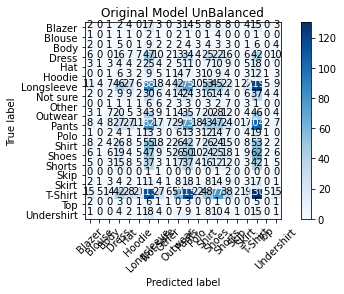

In [19]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Original Model UnBalanced')

### Conclusions

We can see the next results

## Original data Balanced


In [20]:
cp_path = "checkPoints/modelTraining_original_balanced"
cp_file = "/cp-{epoch:04d}.ckpt"
cp_callback_original_balanced= checkPointCreation(cp_path+cp_file)
class_weight_dict_org = generateWeights(train_set.labels)

{0: 2.2262886597938145, 1: 13.496875, 2: 4.1528846153846155, 3: 0.8088014981273408, 4: 1.9110619469026549, 5: 2.3220430107526884, 6: 0.3517100977198697, 7: 1.1365789473684211, 8: 5.39875, 9: 0.8242366412213741, 10: 0.3890990990990991, 11: 2.0764423076923078, 12: 0.6484984984984985, 13: 0.6446268656716417, 14: 0.9555309734513274, 15: 43.19, 16: 1.9995370370370371, 17: 0.2702753441802253, 18: 8.997916666666667, 19: 2.511046511627907}


In [21]:
originalModel_balanced = generateModel(num_classes)
originalModel_balanced.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [22]:
currentEpoch, file = load_weights("checkPoints/modelTraining_original_balanced")
if(currentEpoch != 0):
    originalModel_balanced.load_weights(file)
originalModel_balanced.fit(train_set,epochs=EPOCHS, initial_epoch = currentEpoch,verbose=True,validation_data=val_set, callbacks=[cp_callback_original_balanced], class_weight = class_weight_dict_org)

Getting weights
not this
checkPoints/modelTraining_original_balanced\cp-0001.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0001.ckpt
checkPoints/modelTraining_original_balanced\cp-0002.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0002.ckpt
checkPoints/modelTraining_original_balanced\cp-0003.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0003.ckpt
checkPoints/modelTraining_original_balanced\cp-0004.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0004.ckpt
checkPoints/modelTraining_original_balanced\cp-0005.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0005.ckpt
checkPoints/modelTraining_original_balanced\cp-0006.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0006.ckpt
checkPoints/modelTraining_original_balanced\cp-0007.ckpt.data-00000-of-00001
checkPoints/modelTraining_original_balanced\cp-0007.ckpt
checkPoints/modelTraining_original_ba

In [23]:
if(currentEpoch < EPOCHS):
    originalModel_balanced.save('saved_model/pantsModel_original_balanced')

### Visualizing

In [24]:
originalModel_balanced = models.load_model('saved_model/pantsModel_original_balanced')
predictions = originalModel_balanced.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
originalModel_balanced.evaluate(train_set)

135/135 [==============================] - 163s 1s/step - loss: 0.6346 - accuracy: 0.7962


[0.6345803141593933, 0.7962491512298584]

Confusion matrix, without normalization
[[  3   0   0   6   7   0  17   7   2   4  11   4  11   5   7   0   2   9
    0   2]
 [  0   0   0   3   1   0   0   1   0   1   2   0   0   0   3   0   0   4
    0   1]
 [  3   2   0   6   0   1   5   7   1   3   6   3   3   1   0   0   4   4
    0   3]
 [  7   0   4  23  13   6  22  22   2  19  22   8  22  21  23   0   8  34
    3   8]
 [  3   0   0  10   4   0  18   4   0  14  16   4   4  12   5   1   3   9
    1   5]
 [  2   0   0   5   4   3  16   6   2   4  10   2   7   8  10   0   1  10
    1   2]
 [ 15   1  15  50  17  12  75  36  11  44  69  24  37  40  48   1  16  73
    3  27]
 [  7   1   1  19   8   4  36   7   2  15  22   9  10   8  12   0   3  20
    0   6]
 [  1   1   0   1   3   0   4   3   1   2   4   3   1   2   2   0   2   8
    0   2]
 [  4   2   5  24  11   6  32  17   5  26  23   8  19  20  18   0   1  28
    2  11]
 [ 19   4  14  41  20   9  70  36   7  23  70  17  40  40  41   0  12  62
    5  25]
 [  4   1   0   7   6   1

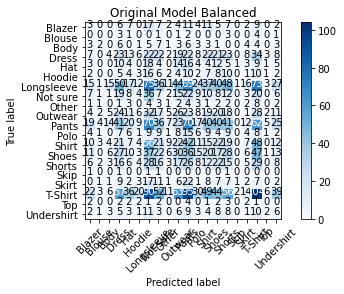

In [25]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Original Model Balanced')

### Conclusions

Conclusion

# Simplifying Dataset

## Data cleaning

Since most of the data has been categorized, and we are mostly interested on some of the labels, and not all, to simplify and improve the training process, we are going to remove some of the categories. And transform them into a single type. We will transform those labels into, Top, Shorts, Pants, and remove some

The label Top will contain:
T-Shirt

The label Bottom will contain:
Pants

The other Shorts will contain:
Shorts

The removed ones will be:
Skirt
Dress
OutWear
Hat
Blazer
Hoodie
Skip
Blouse
Top
Polo
Undershirt
LongSleeve
Shirt

In [26]:
imagesPath = 'Data/images_compressed'
dataCSV = originalCSV.copy()
dataCSV['image'] = imagesPath + '/' + originalCSV['image'] +'.jpg' #We adjust the data so that it is well defined
dataCSV.dropna()

dataCSV.loc[dataCSV['label'] == 'T-Shirt','label'] = 'Top'

dataCSV.loc[dataCSV['label'] == 'Pants','label'] = 'Bottom_Long'

dataCSV.loc[dataCSV['label'] == 'Shorts','label'] = 'Bottom_Short'

newColumns = ['Top','Bottom_Long', 'Bottom_Short']
finalData = dataCSV.loc[dataCSV["label"].str.contains("Top|Bottom_Long|Bottom_Short")]
data_df = finalData[['image', 'label']]

Now we can check our new data

In [27]:
typeOfData = data_df["label"].value_counts()
data_df.head()

,image,label
1,Data/images_compressed/ea7b6656-3f84-4eb3-9099...,Top
3,Data/images_compressed/ea2ffd4d-9b25-4ca8-9dc2...,Top
5,Data/images_compressed/5d3a1404-697f-479f-9090...,Bottom_Short
7,Data/images_compressed/4c8f245e-a039-46fd-a6b9...,Top
8,Data/images_compressed/c995c900-693d-4dd6-8995...,Bottom_Long


In [28]:
train_set, val_set, num_classes = createTrainSetAndValidationSet(data_df)

Found 1644 validated image filenames belonging to 3 classes.
Found 410 validated image filenames belonging to 3 classes.
Total classes: 3


## Unbalanced data

We will first try with an unbalanced weighting on the data

In [33]:
cp_path = "checkPoints/modelTraining_unbalanced/cp-{epoch:04d}.ckpt"
cp_callback_unbalanced= checkPointCreation(cp_path)

In [34]:
unbalancedModel = generateModel(num_classes)
unbalancedModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [37]:
currentEpoch, file = load_weights("checkPoints/modelTraining_unbalanced")
if(currentEpoch != 0):
    unbalancedModel.load_weights(file)
unbalancedModel.fit(train_set,epochs=EPOCHS, initial_epoch = currentEpoch, verbose=True,validation_data=val_set, callbacks=[cp_callback_unbalanced]) 

Getting weights
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 15.7310 - accuracy: 0.4367
Epoch 1: saving model to checkPoints/modelTraining_unbalanced\cp-0001.ckpt
52/52 [==============================] - 309s 6s/step - loss: 15.7310 - accuracy: 0.4367 - val_loss: 13502.8076 - val_accuracy: 0.5049
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 10.2792 - accuracy: 0.4568
Epoch 2: saving model to checkPoints/modelTraining_unbalanced\cp-0002.ckpt
52/52 [==============================] - 304s 6s/step - loss: 10.2792 - accuracy: 0.4568 - val_loss: 1.1250 - val_accuracy: 0.5049
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 3.6818 - accuracy: 0.4970
Epoch 3: saving model to checkPoints/modelTraining_unbalanced\cp-0003.ckpt
52/52 [==============================] - 303s 6s/step - loss: 3.6818 - accuracy: 0.4970 - val_loss: 1.3296 - val_accuracy: 0.1854
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 2.7035 - ac

In [38]:
if(currentEpoch < EPOCHS):
    unbalancedModel.save('saved_model/pantsModel_unbalanced')

INFO:tensorflow:Assets written to: saved_model/pantsModel_unbalanced\assets


### Visualizing

In [39]:
unbalancedModel = models.load_model('saved_model/pantsModel_unbalanced')
predictions = unbalancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
unbalancedModel.evaluate(train_set)

52/52 [==============================] - 62s 1s/step - loss: 0.2180 - accuracy: 0.9355


[0.21799489855766296, 0.9355230927467346]

Confusion matrix, without normalization
[[186  64 315]
 [ 75  27 130]
 [288 107 452]]


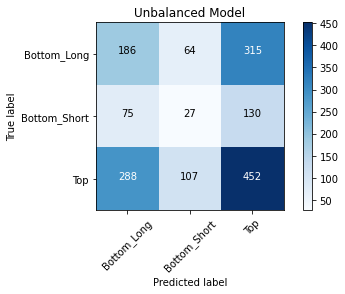

In [40]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Unbalanced Model')

### Conclusions

Conclusions

## Balanced Model

We will also train a blanaced Model, having some balanced weights to use

In [41]:
cp_path = "checkPoints/modelTraining_balanced/cp-{epoch:04d}.ckpt"
cp_callback_balanced= checkPointCreation(cp_path)
class_weight_dict = generateWeights(train_set.labels)

{0: 0.9699115044247788, 1: 2.3620689655172415, 2: 0.6469893742621016}


In [42]:
balancedModel = generateModel(num_classes)
balancedModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization) 

 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_blo

 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_blo

In [43]:
currentEpoch, file = load_weights("checkPoints/modelTraining_balanced")
if(currentEpoch != 0):
    balancedModel.load_weights(file)    
balancedModel.fit(train_set,epochs=EPOCHS,initial_epoch = currentEpoch, verbose=True,validation_data=val_set, callbacks=[cp_callback_balanced], class_weight = class_weight_dict)

Getting weights
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 19.1848 - accuracy: 0.3273
Epoch 1: saving model to checkPoints/modelTraining_balanced\cp-0001.ckpt
52/52 [==============================] - 316s 6s/step - loss: 19.1848 - accuracy: 0.3273 - val_loss: 1.0242 - val_accuracy: 0.5049
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 9.1202 - accuracy: 0.3485
Epoch 2: saving model to checkPoints/modelTraining_balanced\cp-0002.ckpt
52/52 [==============================] - 309s 6s/step - loss: 9.1202 - accuracy: 0.3485 - val_loss: 1583.5045 - val_accuracy: 0.5049
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 11.3868 - accuracy: 0.4142
Epoch 3: saving model to checkPoints/modelTraining_balanced\cp-0003.ckpt
52/52 [==============================] - 310s 6s/step - loss: 11.3868 - accuracy: 0.4142 - val_loss: 4857.2798 - val_accuracy: 0.4024
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 5.1745 - accura

In [44]:
if(currentEpoch < EPOCHS):
    balancedModel.save('saved_model/pantsModel_balanced')

INFO:tensorflow:Assets written to: saved_model/pantsModel_balanced\assets


### Visualizing

In [45]:
balancedModel = models.load_model('saved_model/pantsModel_balanced')
predictions = balancedModel.predict(train_set)
rounded_predictions = np.argmax(predictions, axis=-1)
balancedModel.evaluate(train_set)

52/52 [==============================] - 62s 1s/step - loss: 0.3428 - accuracy: 0.8856


[0.3427966833114624, 0.885644793510437]

Confusion matrix, without normalization
[[187 107 271]
 [ 70  45 117]
 [315 172 360]]


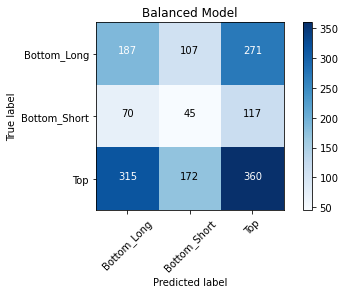

In [46]:
cm = confusion_matrix(y_true=train_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=train_set.class_indices, title='Balanced Model')

### Conclusions

# First conclusions

It is clear that by just using transfer learning as show before, the results are bad, therefore i shall find a better way. Possible options are using a differential learning rate.

Instead of unfreezing specific layers, it’s probably a better idea to use a differential learning rate, where the learning rate is determined on a per-layer basis. The bottom layers will then have a very low learning rate, as these generalise quite well, responding principally to edges, blobs and other trivial geometries, whereas the layers responding to more complex features will have a larger learning rate. In the past, the 2:4:6 rule (negative powers of 10) has worked quite well for me — using a learning rate of 10^-6 for the bottommost few layers, 10^-4 for the other transfer layers and 10^-2 for any additional layers we added. I have also heard others using 2:3:4:5:6 or 2:3:4 with different architectures. For ResNets and their derivatives, I have always felt more comfortable with 2:4:6 than 2:3:4, but I have absolutely no empirical evidence to back this up with. (https://medium.com/starschema-blog/transfer-learning-the-dos-and-donts-165729d66625)

Also, redoing it from scratch,

When transferring to a task with a relatively large data set, you might want to train the network from scratch (which would make it not transfer learning at all). At the same time — given that such a network would be initialised with random values, you have nothing to lose by using the pretrained weights! Unfreeze the entire network, remove the output layer and replace it with one matching the number of destination task classes, and fine-tune the whole network.

Same reference

# HeatMap visualization

In [47]:
modelTest = models.load_model('saved_model/pantsModel_unbalanced')

[[0. 0. 1.]]


C:\Users\pauso\AppData\Local\Temp\ipykernel_16940\3815959611.py:18: RuntimeWarning: invalid value encountered in true_divide
  heatmap /= np.max(heatmap)


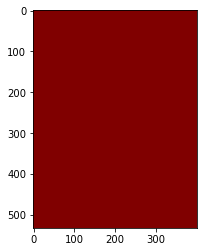

In [48]:
def gradCAM(orig, model, intensity=0.5, res=224):
    img = image.load_img(orig, target_size=(res, res))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    print((preds)) # prints the class of image
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv5_block3_out')
        iterate = models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(x)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))
    img = cv2.imread(orig)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    img = img
    plt.imshow(heatmap)

gradCAM(r'Data\images_compressed\1b065c3c-0679-40af-9924-8de9986fdf66.jpg', modelTest)

# Improvement options

Let's make a list of some options to improve this overffiting results that we are getting:
- Cross-validation will allow us to know if we are having good data
- Unfreezing some of the layers might improve accuracy
- Unfreezing some of the layers at the end might improve accuracy
- Trying a different model than ResNet50 might improve accuracy
- Data augmentation might improve results

## Trying cross-validation to learn overfitting results

Trying to improve our model, we can test out

## Trying diferent model methods for overfitting improvement

In [ ]:
np.max(heatma p)

## Including label with a modified dataset